In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import glob
from IPython.display import display
import sys

In [36]:
%load_ext autoreload
%autoreload 2
sys.path.insert(0, '../../scripts')
from plot_helpers import nice_name_map, plot_scatter_with_lines, save_plot

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
benchmark_results = []
for path in glob.glob('../../benchmarks/2020-12-15-independent-small-regen-1/*.csv'):
    benchmark_results.append(pd.read_csv(path))
benchmark_results = pd.concat(benchmark_results)

benchmark_results.sample(5)

,generation_config_i,input_strategy,input_length_1,input_change_strength,input_chunkiness,input_distribution,regen_i,repetition_i,diff_program,mpi_procs,timeout_seconds,mpi_comm_world,micros_input,micros_precompute,micros_until_len,micros_edit_script,min_edit_length
136,6,independent,100000,1,0,zipf,0,19,sequential_frontier,NaN,NaN,1,18654,0,55782582,0,171020
39,0,independent,30000,1,0,zipf,0,39,sequential_frontier,NaN,NaN,1,4794,0,5440183,0,50372
74,2,independent,53333,1,0,zipf,0,24,sequential_frontier_simd,NaN,NaN,1,11439,0,13266393,0,90320
40,5,independent,88333,1,0,zipf,0,4,mpi_priority_frontier_simd,2.0,60.0,2,16837,0,12045561,0,150966
160,6,independent,100000,1,0,zipf,0,10,mpi_no_master_frontier,64.0,60.0,64,409192,0,903122,0,171020


In [4]:
def agg_median_or_all_equal(values):
    if pd.isnull(values).all():
        return values.iloc[0]
    test_value = values.dropna().iloc[0]
    if (values.dropna() == test_value).all():
        return test_value
    return values.median()

def prepare_plot_data(filter_cb, index, map_cb = lambda temp: temp):
    temp = benchmark_results.copy()
    temp = map_cb(temp)
    temp['mpi_procs'] = temp['mpi_procs'].fillna('sequential')
    temp = temp.groupby(['generation_config_i', 'mpi_procs', 'diff_program']).agg(agg_median_or_all_equal)
    temp = filter_cb(temp)
    temp = temp.set_index(index, append=True)
    temp = temp.unstack('mpi_procs')['micros_until_len']
    temp = temp.droplevel('generation_config_i')
    temp = temp.sort_index()
    return temp

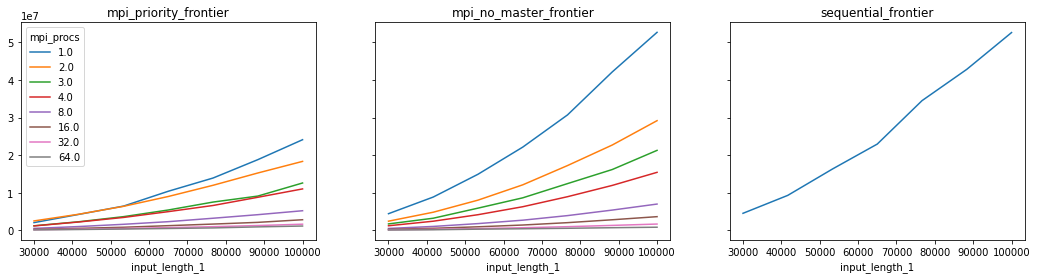

In [5]:
fig, ax = plt.subplots(1, 3, figsize=(18, 4), sharex=True, sharey=True)
for diff_program_i, diff_program in enumerate(['mpi_priority_frontier', 'mpi_no_master_frontier', 'sequential_frontier']):
    temp = prepare_plot_data(
        lambda temp: temp[(temp.index.get_level_values('diff_program') == diff_program) & (temp['input_strategy'] == 'independent')],
        'input_length_1',
    )
    temp = temp.droplevel('diff_program')
    temp.plot(ax=ax[diff_program_i], legend=(diff_program_i == 0), title=diff_program);

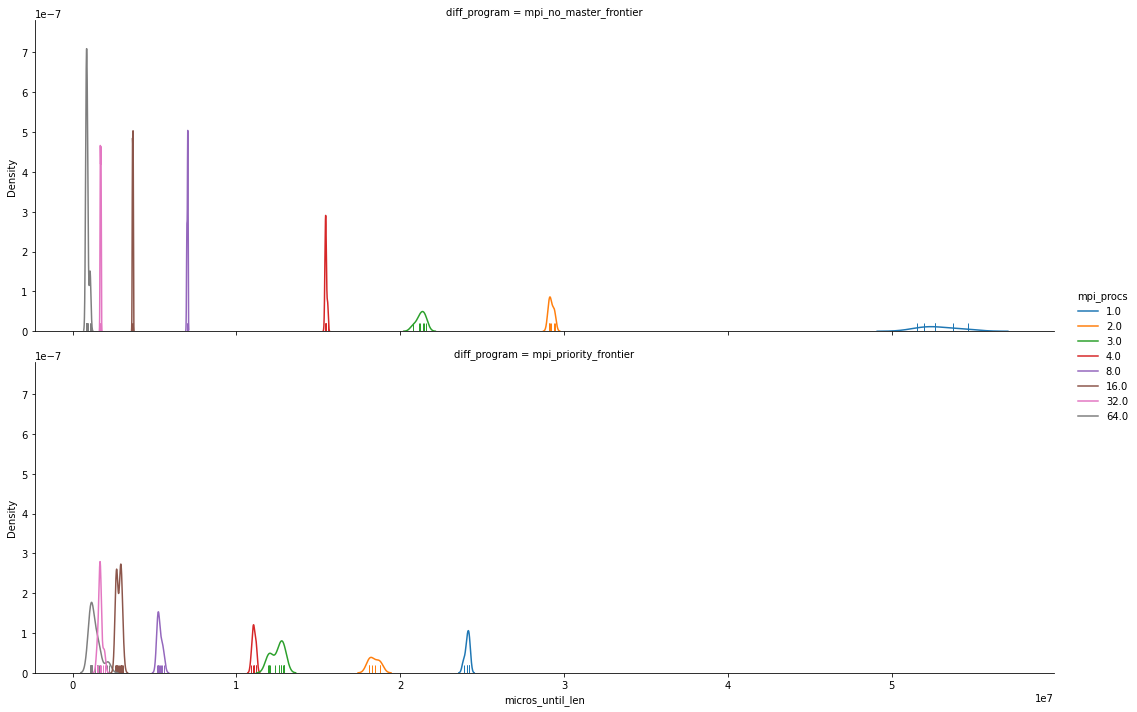

In [6]:
temp = benchmark_results.copy()
temp = temp[((temp['diff_program'] == 'mpi_priority_frontier') | (temp['diff_program'] == 'mpi_no_master_frontier')) & (temp['input_strategy'] == 'independent') & (temp['input_length_1'] == temp['input_length_1'].max())]
assert len(temp['generation_config_i'].unique()) == 1
temp = temp[['diff_program', 'mpi_procs', 'repetition_i', 'micros_until_len']]

palette = {mpi_procs: color for mpi_procs, color in zip(sorted(temp.mpi_procs.dropna().unique()), sns.color_palette())}
sns.displot(temp, kind='kde', rug=True, x='micros_until_len', row='diff_program', hue='mpi_procs', palette=palette, aspect=3);

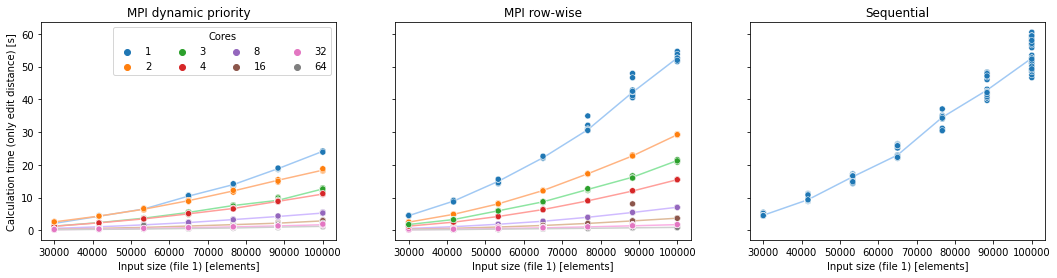

In [37]:
palette = {mpi_procs: color for mpi_procs, color in zip(sorted(benchmark_results.mpi_procs.dropna().unique()), sns.color_palette())}
fig, ax = plt.subplots(1, 3, figsize=(18, 4), sharex=True, sharey=True)
for diff_program_i, diff_program in enumerate(['mpi_priority_frontier', 'mpi_no_master_frontier', 'sequential_frontier']):
    temp = benchmark_results.copy()
    temp['seconds_until_len'] = temp['micros_until_len'] * 1e-6
    temp['mpi_procs'] = temp['mpi_procs'].fillna(1)
    temp = temp[(temp['diff_program'] == diff_program) & (temp['input_strategy'] == 'independent')]
    
    temp_2 = temp.groupby(['input_length_1', 'mpi_procs'])['seconds_until_len'].median().unstack('mpi_procs')
    
    this_ax = ax[diff_program_i]
    plot_scatter_with_lines(
        ax=this_ax,
        scatter_data=temp,
        line_data=temp_2,
        x_key='input_length_1',
        y_key='seconds_until_len',
        hue_key='mpi_procs',
        show_legend=diff_program_i == 0,
    )
    this_ax.set_title(nice_name_map[diff_program])

save_plot(fig, 'independent-small-raw-times')

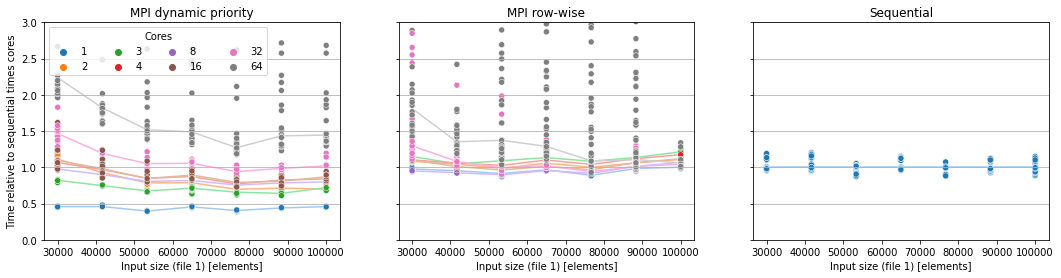

In [38]:
palette = {mpi_procs: color for mpi_procs, color in zip(sorted(benchmark_results.mpi_procs.dropna().unique()), sns.color_palette())}
fig, ax = plt.subplots(1, 3, figsize=(18, 4), sharex=True, sharey=True)
for diff_program_i, diff_program in enumerate(['mpi_priority_frontier', 'mpi_no_master_frontier', 'sequential_frontier']):
    temp = benchmark_results.copy()
    temp['mpi_procs'] = temp['mpi_procs'].fillna(1)
    temp = temp[temp['input_strategy'] == 'independent']
    temp = temp.set_index(['generation_config_i', 'mpi_procs', 'diff_program', 'repetition_i'])
    temp_2 = temp.xs(diff_program, level='diff_program').set_index("input_length_1", append=True)["micros_until_len"].unstack("mpi_procs").droplevel(0).swaplevel()
    temp_3 = temp.xs('sequential_frontier', level='diff_program').groupby("input_length_1").median()["micros_until_len"]
    temp = temp_2.divide(temp_3, level='input_length_1', axis=0)
    temp *= temp.columns.values
    temp = temp.stack().to_frame().rename(columns={0: 'time_relative_to_sequential'}).reset_index()
    
    temp_2 = temp.groupby(['input_length_1', 'mpi_procs'])['time_relative_to_sequential'].median().unstack('mpi_procs')
    
    this_ax = ax[diff_program_i]
    plot_scatter_with_lines(
        ax=this_ax,
        scatter_data=temp,
        line_data=temp_2,
        x_key='input_length_1',
        y_key='time_relative_to_sequential',
        hue_key='mpi_procs',
        show_legend=diff_program_i == 0,
    )
    this_ax.set_title(nice_name_map[diff_program])
    this_ax.set_ylim(0, 3)
    this_ax.grid(axis='y')
    
save_plot(fig, 'independent-small-sequential-relative')

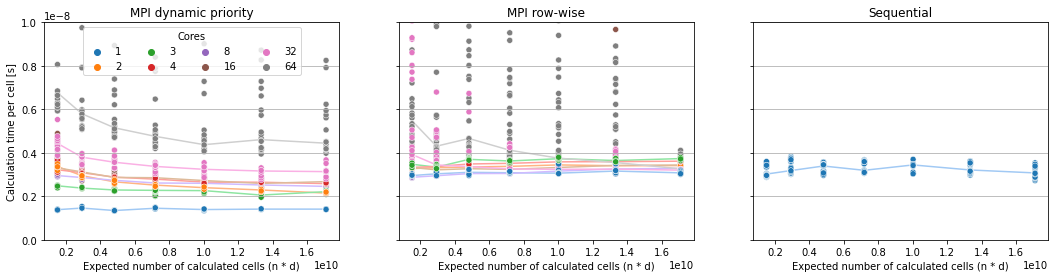

In [42]:
palette = {mpi_procs: color for mpi_procs, color in zip(sorted(benchmark_results.mpi_procs.dropna().unique()), sns.color_palette())}
fig, ax = plt.subplots(1, 3, figsize=(18, 4), sharex=True, sharey='row')
for diff_program_i, diff_program in enumerate(['mpi_priority_frontier', 'mpi_no_master_frontier', 'sequential_frontier']):
    temp = benchmark_results.copy()
    temp['mpi_procs'] = temp['mpi_procs'].fillna(1)
    temp = temp[(temp['diff_program'] == diff_program) & (temp['input_strategy'] == 'independent')]
    temp['nd'] = temp['input_length_1'] * temp['min_edit_length']
    temp['seconds_per_cell'] = temp['micros_until_len'] * temp['mpi_procs'].fillna(1) / temp['nd'] * 1e-6

    temp_2 = temp.groupby(['nd', 'mpi_procs'])['seconds_per_cell'].median().unstack('mpi_procs')

    this_ax = ax[diff_program_i]
    plot_scatter_with_lines(
        ax=this_ax,
        scatter_data=temp,
        line_data=temp_2,
        x_key='nd',
        y_key='seconds_per_cell',
        hue_key='mpi_procs',
        show_legend=diff_program_i == 0,
    )
    this_ax.set_title(nice_name_map[diff_program])
    this_ax.set_ylim(0, 1e-8)
    this_ax.grid(axis='y')
        
save_plot(fig, 'independent-small-cell-times')

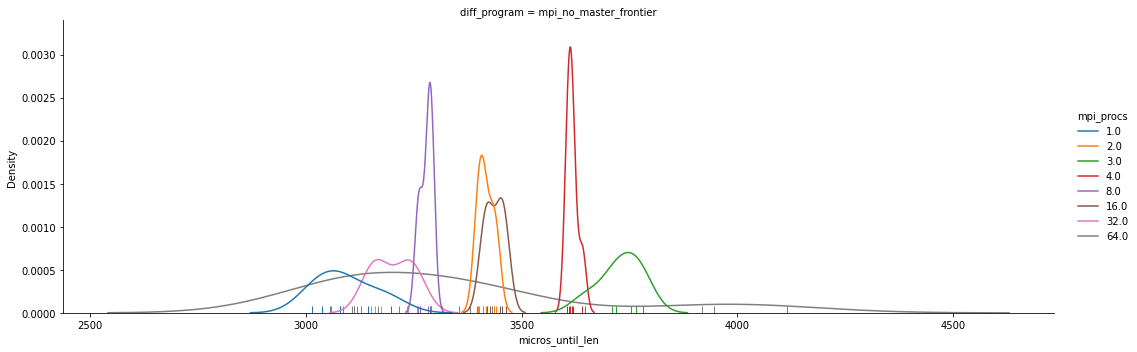

In [134]:
temp = benchmark_results.copy()
temp = temp[(temp['diff_program'] == 'mpi_no_master_frontier') & (temp['input_strategy'] == 'independent') & (temp['input_length_1'] == temp['input_length_1'].max())]
assert len(temp['generation_config_i'].unique()) == 1
temp['nd'] = temp['input_length_1'] * temp['min_edit_length']
temp['micros_until_len'] = temp['micros_until_len'] * temp['mpi_procs'].fillna(1) / temp['nd']
temp['micros_until_len'] *= 1e6 # HACK otherwise plot won't show (https://github.com/mwaskom/seaborn/issues/2294)

palette = {mpi_procs: color for mpi_procs, color in zip(sorted(temp.mpi_procs.dropna().unique()), sns.color_palette())}
sns.displot(temp, kind='kde', rug=True, x='micros_until_len', row='diff_program', hue='mpi_procs', palette=palette, aspect=3);

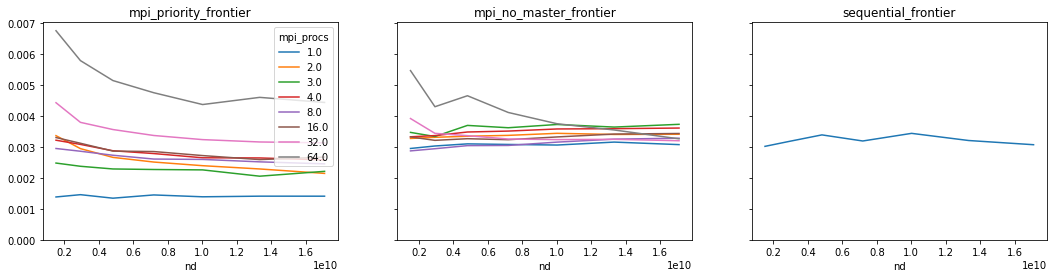

In [28]:
def map_data_for_plot(temp):
    temp['nd'] = temp['input_length_1'] * temp['min_edit_length']
    temp['micros_until_len'] = temp['micros_until_len'] * temp['mpi_procs'].fillna(1) / temp['nd']
    return temp

fig, ax = plt.subplots(1, 3, figsize=(18, 4), sharex=True, sharey=True)
for diff_program_i, diff_program in enumerate(['mpi_priority_frontier', 'mpi_no_master_frontier', 'sequential_frontier']):
    temp = prepare_plot_data(
        lambda temp: temp[(temp.index.get_level_values('diff_program') == diff_program) & (temp['input_strategy'] == 'independent')],
        'nd',
        map_data_for_plot
    )
    temp = temp.droplevel('diff_program')
    temp.plot(ax=ax[diff_program_i], legend=(diff_program_i == 0), title=diff_program, ylim=(0, None));

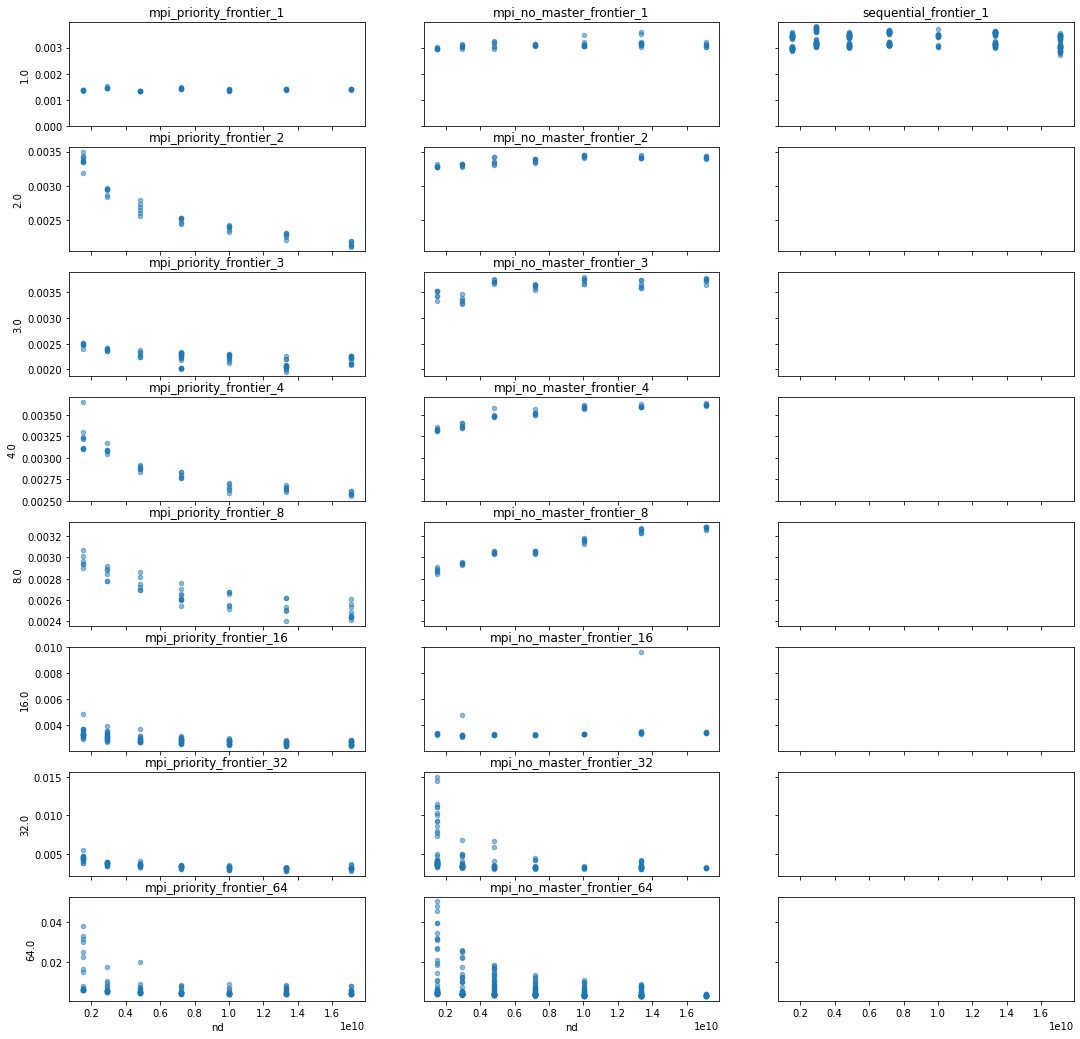

In [7]:
fig, ax = plt.subplots(8, 3, figsize=(18, 18), sharex=True, sharey='row')
for diff_program_i, diff_program in enumerate(['mpi_priority_frontier', 'mpi_no_master_frontier', 'sequential_frontier']):
    temp = benchmark_results.copy()
    temp['mpi_procs'] = temp['mpi_procs'].fillna(1)
    temp['nd'] = temp['input_length_1'] * temp['min_edit_length']
    temp['micros_until_len'] = temp['micros_until_len'] * temp['mpi_procs'] / temp['nd']
    temp = temp.set_index(['generation_config_i', 'mpi_procs', 'diff_program', 'repetition_i'])
    temp = temp[(temp.index.get_level_values('diff_program') == diff_program) & (temp['input_strategy'] == 'independent')]
    temp = temp.set_index('nd', append=True)
    temp = temp.unstack('mpi_procs')['micros_until_len']
    temp = temp.droplevel('generation_config_i')
    temp = temp.sort_index()
    temp = temp.droplevel('diff_program')
    temp['nd'] = temp.index.get_level_values('nd').values
    for column_i, column in enumerate(temp.columns):
        if column != 'nd':
            temp.plot.scatter(x='nd', y=column, ax=ax[column_i][diff_program_i], legend=False, title=f'{diff_program}_{int(column)}', alpha=0.5);
            if diff_program_i == 2:
                ax[column_i][diff_program_i].set_ylim(bottom=0)

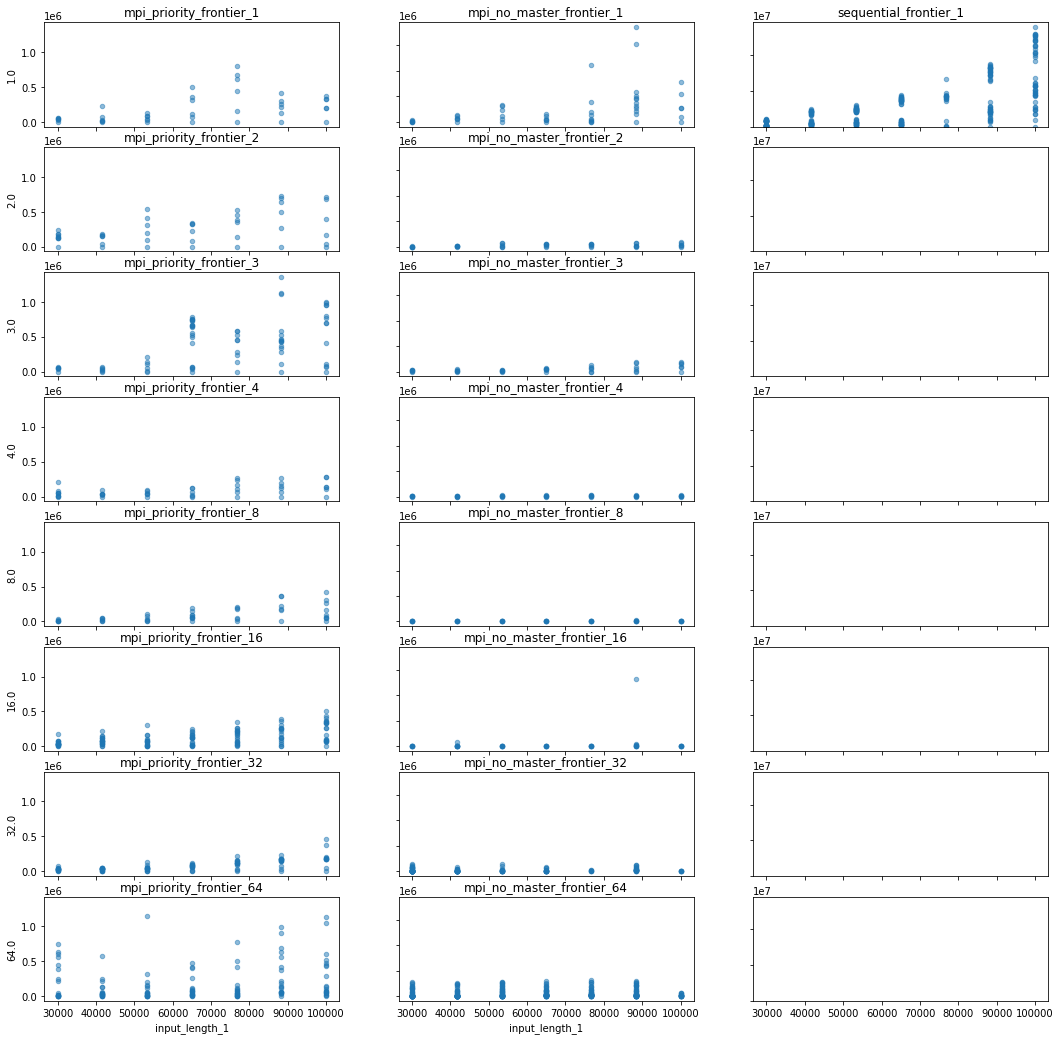

In [8]:
fig, ax = plt.subplots(8, 3, figsize=(18, 18), sharex=True, sharey='col')
for diff_program_i, diff_program in enumerate(['mpi_priority_frontier', 'mpi_no_master_frontier', 'sequential_frontier']):
    temp = benchmark_results.copy()
    temp['mpi_procs'] = temp['mpi_procs'].fillna(1)
    temp = temp.set_index(['generation_config_i', 'mpi_procs', 'diff_program', 'repetition_i'])
    temp['micros_until_len'] -= temp['micros_until_len'].groupby(level=['generation_config_i', 'mpi_procs', 'diff_program']).min()
    temp = temp[(temp.index.get_level_values('diff_program') == diff_program) & (temp['input_strategy'] == 'independent')]
    temp = temp.set_index('input_length_1', append=True)
    temp = temp.unstack('mpi_procs')['micros_until_len']
    temp = temp.droplevel('generation_config_i')
    temp = temp.sort_index()
    temp = temp.droplevel('diff_program')
    temp['input_length_1'] = temp.index.get_level_values('input_length_1').values
    for column_i, column in enumerate(temp.columns):
        if column != 'input_length_1':
            temp.plot.scatter(x='input_length_1', y=column, ax=ax[column_i][diff_program_i], legend=False, title=f'{diff_program}_{int(column)}', alpha=0.5);
            if diff_program_i == 2:
                ax[column_i][diff_program_i].set_ylim(bottom=0)

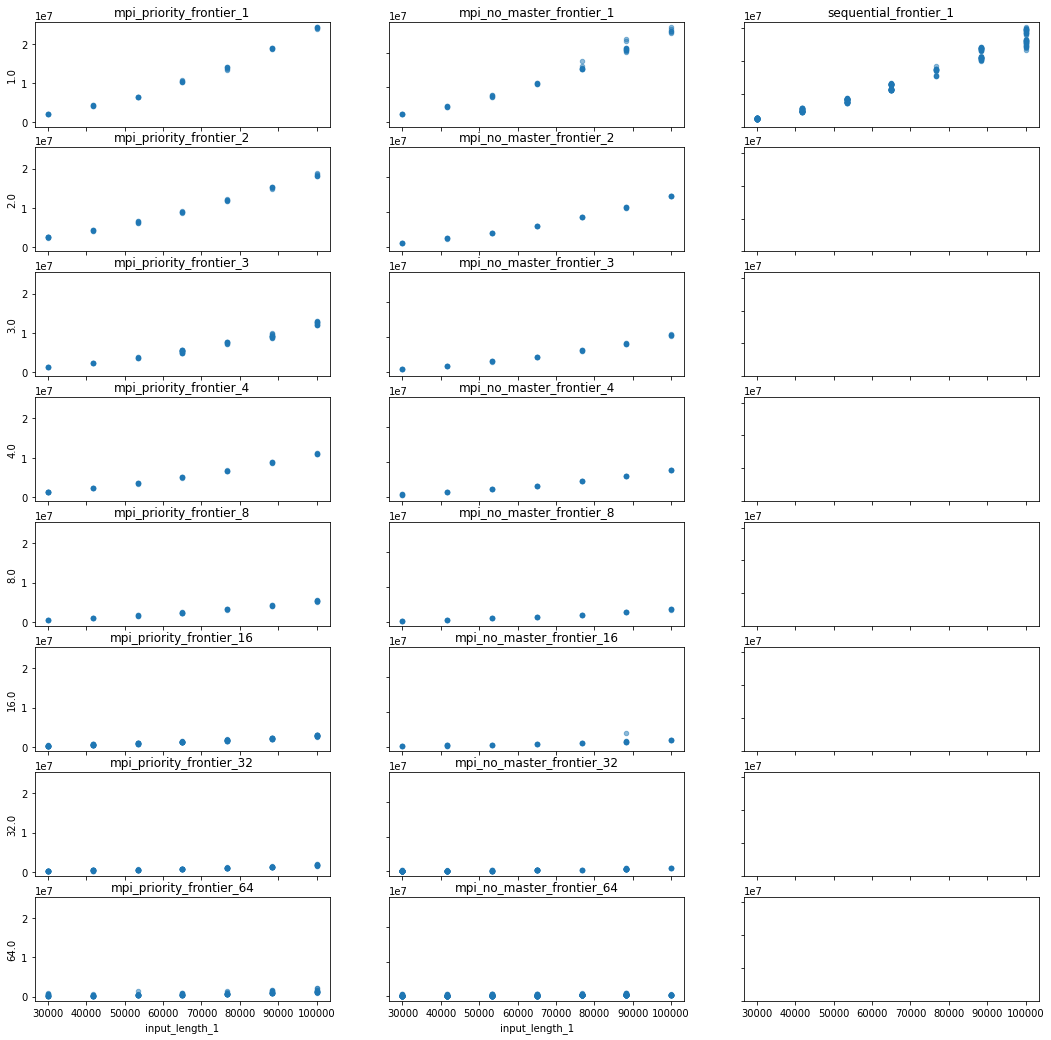

In [9]:
fig, ax = plt.subplots(8, 3, figsize=(18, 18), sharex=True, sharey='col')
for diff_program_i, diff_program in enumerate(['mpi_priority_frontier', 'mpi_no_master_frontier', 'sequential_frontier']):
    temp = benchmark_results.copy()
    temp['mpi_procs'] = temp['mpi_procs'].fillna(1)
    temp = temp.set_index(['generation_config_i', 'mpi_procs', 'diff_program', 'repetition_i'])
    temp = temp[(temp.index.get_level_values('diff_program') == diff_program) & (temp['input_strategy'] == 'independent')]
    temp = temp.set_index('input_length_1', append=True)
    temp = temp.unstack('mpi_procs')['micros_until_len']
    temp = temp.droplevel('generation_config_i')
    temp = temp.sort_index()
    temp = temp.droplevel('diff_program')
    temp['input_length_1'] = temp.index.get_level_values('input_length_1').values
    for column_i, column in enumerate(temp.columns):
        if column != 'input_length_1':
            temp.plot.scatter(x='input_length_1', y=column, ax=ax[column_i][diff_program_i], legend=False, title=f'{diff_program}_{int(column)}', alpha=0.5);
            if diff_program_i == 2:
                ax[column_i][diff_program_i].set_ylim(bottom=0)

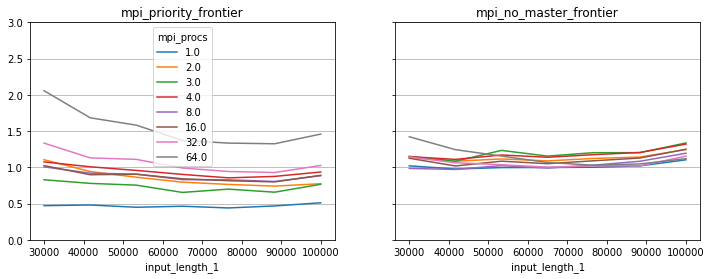

In [186]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)
for diff_program_i, diff_program in enumerate(['mpi_priority_frontier', 'mpi_no_master_frontier']):
    temp = benchmark_results.copy()
    temp['mpi_procs'] = temp['mpi_procs'].fillna('sequential')
    temp = temp.groupby(['generation_config_i', 'mpi_procs', 'diff_program']).min()
    temp = temp[temp['input_strategy'] == 'independent']
    temp_2 = temp.xs(diff_program, level='diff_program').set_index("input_length_1", append=True)["micros_until_len"].unstack("mpi_procs").droplevel(0)
    temp_3 = temp.xs('sequential_frontier', level='diff_program').set_index("input_length_1")["micros_until_len"]
    temp = temp_2.divide(temp_3, axis=0)
    temp *= temp.columns.values
    temp.plot(ax=ax[diff_program_i], legend=(diff_program_i == 0), title=diff_program, ylim=(0, 3), grid=True);
    ax[diff_program_i].grid(axis='x')